Target : predict the sales price for each house (For each Id in the test set)

Fonction-coût : Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# Import librairies & data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

In [2]:
data = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
non_alphanum = [i for i in data.columns if str.isalnum(i)==False]
non_alphanum

# Nous ne constatons aucun caractère non alphanumérique => pas de nettoyage à faire

[]

# Data structure & visualisation

Points de vigilence relevés : 
- significativité des valeurs nulles (ex: piscine en 0 => créer une classe binaire ?)
- outliers importants (target) qui peuvent influencer le modèle
- target non distribuée normalement 

## Data structure

In [5]:
data.shape

(1460, 81)

In [6]:
data_test.shape

(1459, 80)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

38 variables numériques  
43 variables catégorielles

In [8]:
data.isnull().sum().sort_values(ascending=False).head(17) *100/len(data) >= 47
#df.isnull().sum().sort_values(ascending=False)

PoolQC           True
MiscFeature      True
Alley            True
Fence            True
FireplaceQu      True
LotFrontage     False
GarageCond      False
GarageType      False
GarageYrBlt     False
GarageFinish    False
GarageQual      False
BsmtExposure    False
BsmtFinType2    False
BsmtFinType1    False
BsmtCond        False
BsmtQual        False
MasVnrArea      False
dtype: bool

Les features ayant des valeurs nulles à plus de 50% sont : PoolQC, MiscFeature, Alley, Fence, FireplaceQu.  
Vérifier leur distribution et leur pertinence. Que signifie la valeur nulle ? 0 = absence de donnée ou signification réelle ? Selon la distribution de la variable, définir la valeur de remplacement ou suppression ? 

PoolQC = PoolQuality (categorical)  
MiscFeature = Miscellaneous feature not covered in other categories (categorial)  
Alley = Type of alley access to property => à supprimer  
Fence = clôture (categorical) => à supprimer  
FireplaceQu = cheminée (categorical)

### Distribution de la target

In [9]:
data['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Le prix moyen d'un appartement est de 180K dollars, le minimum étant de 34K dollars et le maximum de 755K dollars.  
75% des maisons se situent en dessous de 214K$ => certaines valeurs extrêmes vont être susceptibles d'influencer négativement notre modèle. Différence entre la moyenne et la médiane confirme la présence d'outliers significatifs. 

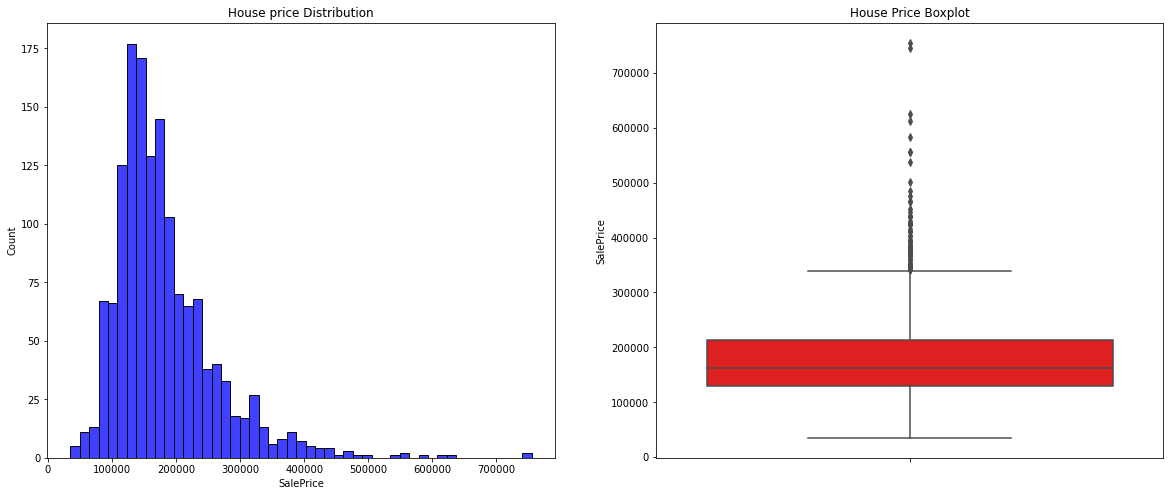

In [10]:
# Analyser la distribution de la target

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.title('House price Distribution')
sns.histplot(data.SalePrice,color ='blue')

plt.subplot(1,2,2)
plt.title('House Price Boxplot')
ax = sns.boxplot(y = data.SalePrice ,color = 'red' )


plt.show()

La distribution est asymétrique et semble ne pas suivre une loi normale => à vérifier avec un qqplot.  
Le boxplot nous confirme la présence d'outliers.  

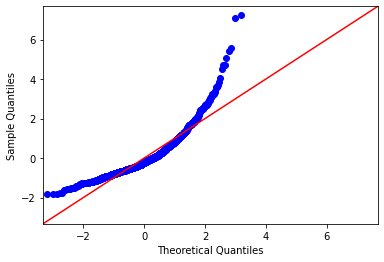

In [11]:
# QQplt - Diagramme Quantile-quantile


sm.qqplot(data['SalePrice'], stats.t, fit=True, line="45")
plt.show()

In [12]:
print("Skewness: %f" % data['SalePrice'].skew())

Skewness: 1.882876


Le coefficient est >1, il indique donc que les données sont fortement biaisées.
Nous avons une skew positive, les valeurs aberrantes sont donc présentes sur le côté droit de notre distribution.

!!! logarithmer la distribution si les résidus ne sont pas homoscédastiques ???? 

### Check des variables numériques

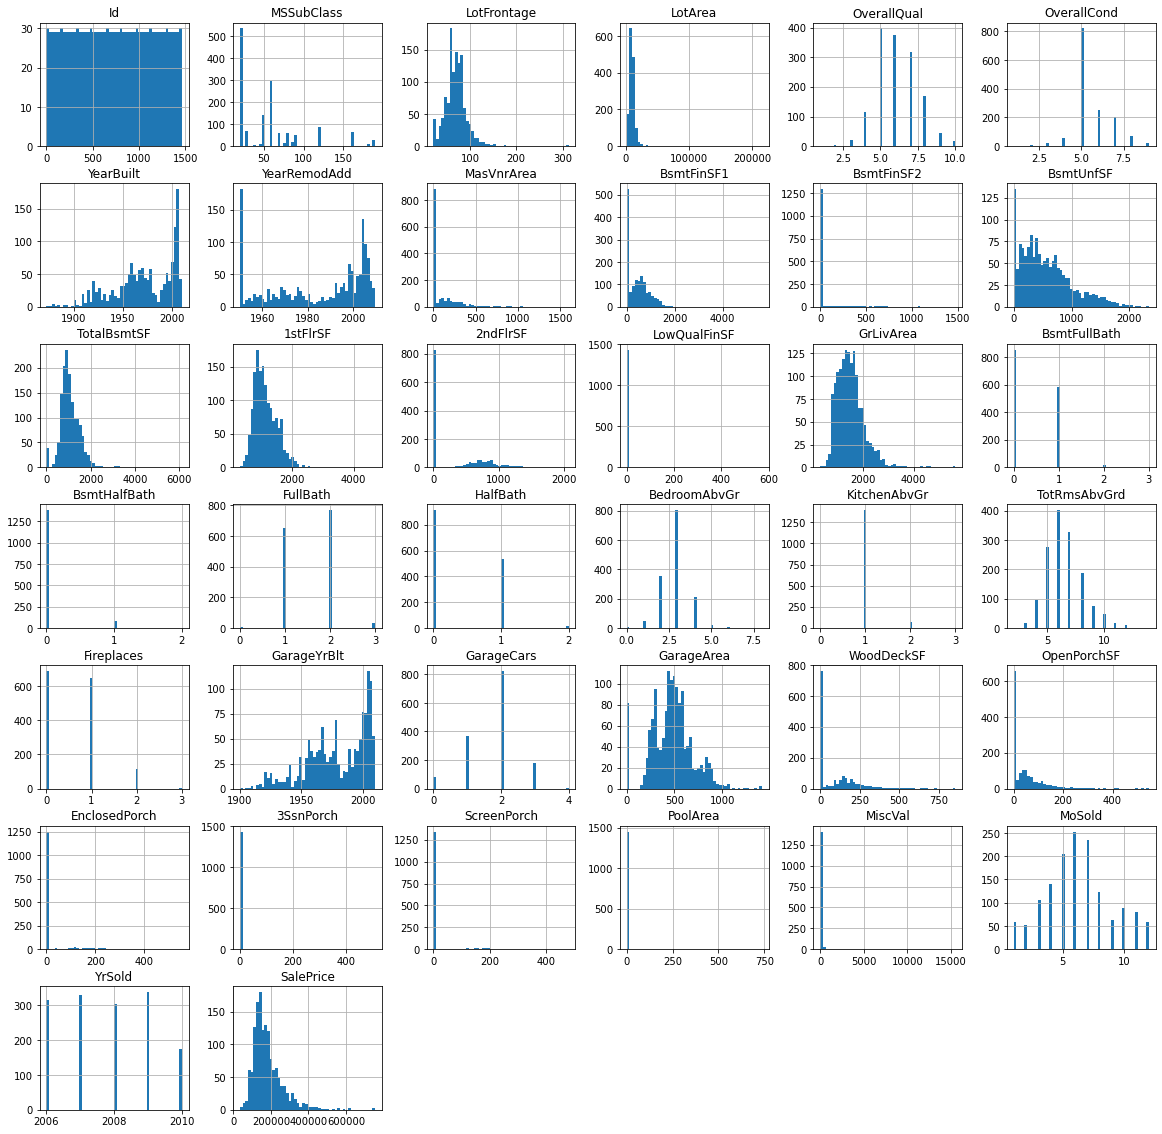

In [13]:
data.hist(bins=50, figsize=(20, 20))
plt.show()

Variables avec distribution non normale / Faire un zoom (changer l'échelle) :

LotFrontage: Linear feet of street connected to property
LotArea: Lot size in square feet

Variables qui présentent beaucoup de 0 et peu de valeurs valorisées => classe 0-1 :
- 2ndFlrSF: Second floor square feet (vérifier la linéarité avec le prix) = explique les outliers ?
- YearRemodAdd = supprimer les 0 s'ils veulent dire qu'on n'a pas l'info ?
- MasVnrArea: Masonry veneer area in square feet

Autres observations qui peuvent constituer du bruit : 
YearRemodAdd: Remodel date (same as construction date if no remodeling or additions) - ne garder que l'année de construction

### Check des variables catégorielles

In [14]:
data.select_dtypes(include=('object'))

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


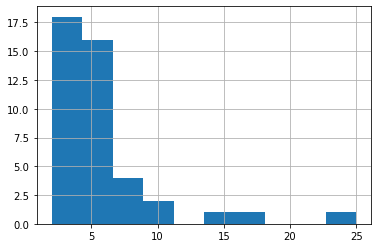

In [15]:
# vérifier le nombre de modalités pour chaque variable catégorielle

data.select_dtypes(include=('object')).nunique().hist()
plt.show()

In [17]:
data.select_dtypes(include=('object')).nunique().sort_values(ascending=False)

Neighborhood     25
Exterior2nd      16
Exterior1st      15
Condition1        9
SaleType          9
Condition2        8
HouseStyle        8
RoofMatl          8
Functional        7
SaleCondition     6
BsmtFinType2      6
Heating           6
Foundation        6
GarageType        6
RoofStyle         6
BsmtFinType1      6
ExterCond         5
BldgType          5
LotConfig         5
MSZoning          5
GarageCond        5
GarageQual        5
HeatingQC         5
Electrical        5
FireplaceQu       5
LotShape          4
LandContour       4
MiscFeature       4
Fence             4
BsmtExposure      4
BsmtCond          4
KitchenQual       4
MasVnrType        4
ExterQual         4
BsmtQual          4
GarageFinish      3
PavedDrive        3
PoolQC            3
LandSlope         3
Utilities         2
CentralAir        2
Alley             2
Street            2
dtype: int64

La majorité des variables catégorielles ont moins de 10 modalités. 

In [18]:
# Inspecter le nom des modalités 

data['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

## Data visualisation

In [19]:
df = data.copy()
df_test = data_test.copy()

### Gérer les outliers

Les modèles de régression linéaire sont sensibles aux outliers => essayer de les corriger au maximum.
Mesure le % d'outliers -> si 10% = les supprimer ?

In [ ]:
## Remove outliers

#train.loc[train['GrLivArea']==5642]

### Gérer la colinéarité

### Categorical features

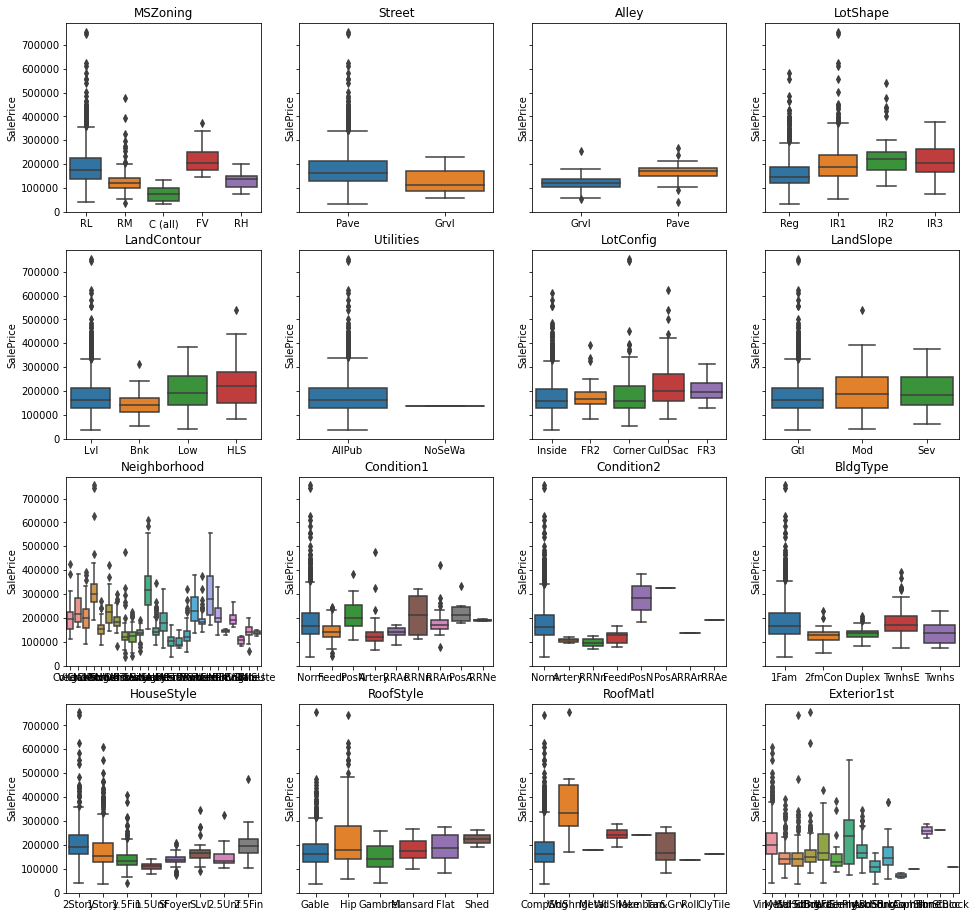

In [24]:
# https://www.kaggle.com/kabure/houseprices-pipeline-featuretools-tpot

fig, axes = plt.subplots(ncols=4, nrows=4, 
                         figsize=(4 * 4, 4 * 4), sharey=True)

axes = np.ravel(axes)

cols = data.select_dtypes(include=('object'))

for i, c in zip(np.arange(len(axes)), cols):
    ax = sns.boxplot(x=c, y='SalePrice', data=df, ax=axes[i])
    ax.set_title(c)
    ax.set_xlabel("")

### Numerical features

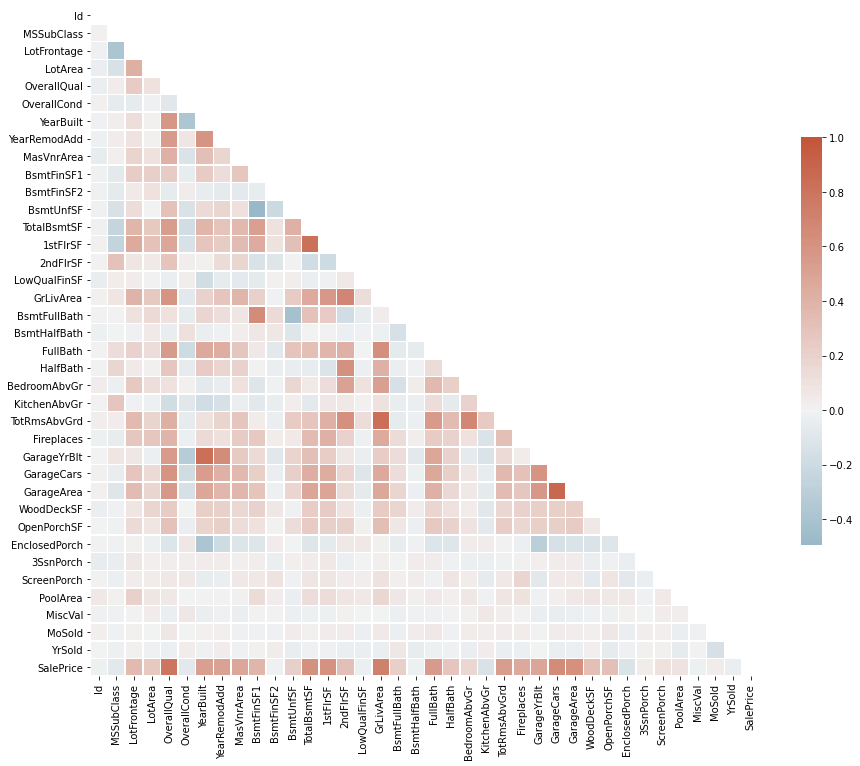

In [26]:
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

# Features selection & engineering

## Features engineering

In [ ]:
# Créer une nouvelle variable / classe avec les équipements qui constituent les outliers

# Création d'une variable "équipement"

PoolArea: Pool area in square (numérique)
PoolQC: Pool quality (catégorielle)

## Features selection

In [ ]:
# Sélection des variables sklearn.feature_selection.SelectFromModel
# Faire un Decicion Tree avec les catégorielles pour voir les variables les plus pertinentes

In [27]:
# Sélection des variables : 
# suppression des features qui ont plus de 50% de valeurs nulles (PoolQC,MiscFeature, Alley, Fence, FireplaceQu)
# suppression des features catégorielles avec plus de 10 modalités (Neighborhood,Exterior2nd, Exterior1st)

X = df.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Neighborhood', 'Exterior2nd', 'Exterior1st', 'FireplaceQu', 'Id', 'SalePrice'], axis=1)
y = df["SalePrice"]

test_columns = df_test.drop(columns=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'Neighborhood', 'Exterior2nd', 'Exterior1st', 'FireplaceQu', 'Id'], axis=1)

In [28]:
X.shape

(1460, 71)

In [29]:
y.shape

(1460,)

# Pre-processing

In [30]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

# pour afficher les pipelines
from sklearn import set_config
set_config(display='diagram')

In [31]:
# Visualisation des varaibles numériques

list(X.select_dtypes(include=['float64', 'int64']))

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [32]:
# Visualisation des variables catégorielles et le nombre de modalités

modalite_feature = pd.DataFrame(X.select_dtypes(include=['object']).nunique().sort_index(axis = 0, ascending = True))
modalite_feature

,0
BldgType,5
BsmtCond,4
BsmtExposure,4
BsmtFinType1,6
BsmtFinType2,6
BsmtQual,4
CentralAir,2
Condition1,9
Condition2,8
Electrical,5


## Split dataset

In [33]:
# split le train / test

from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=5)

print('Train set :', X_train.shape)
print('Test set :', X_test.shape)

Train set : (1168, 71)
Test set : (292, 71)


## Création du pipeline

In [36]:
# Sélection des features numériques et catégoricales (ordinales et à OneHotEncoder)
# On distingue les numerical_features / les categorial_features sur lesquelles on appliquera un encodeur ordinal et 
# OneHot (check variable une par une si ordre de grandeur pertinent ou non)

numerical_features = (list(X.select_dtypes(include=['float', 'integer']).columns.values))
categorical_features_ordinal = ['LotShape','ExterQual', 'ExterCond', 'BsmtQual','BsmtCond','Heating','KitchenQual', 'GarageQual','GarageCond']

categorical_features_OneHot = []

for i in X:
    if i in numerical_features:
        continue
    elif not i in categorical_features_ordinal:
        categorical_features_OneHot.append(i)
# print(categorical_features_OneHot)

In [46]:
# Visualisation des valeurs nulles numériques et catégorielles de ma sélection
# LotFrontage : Linear feet of street connected to property
# GarageYrBlt : year garage was built

X.select_dtypes(include=['float64', 'int64']).isnull().sum()

MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [47]:
X.select_dtypes(include=['object']).isnull().sum()

MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
MasVnrType        8
ExterQual         0
ExterCond         0
Foundation        0
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
KitchenQual       0
Functional        0
GarageType       81
GarageFinish     81
GarageQual       81
GarageCond       81
PavedDrive        0
SaleType          0
SaleCondition     0
dtype: int64

In [48]:
# installation de ce module suite à erreurs relatives à Ordinal Encoder handle_unknow
conda install -c conda-forge category_encoders

SyntaxError: invalid syntax (<ipython-input-48-108289bd7f47>, line 2)

In [49]:
# Remplacer les NaN des valeurs numériques par KNN Imputer (car pas pertinent de remplacer par la moyenne ou la médiane)
# Remplacer les NaN des valeurs catégorielles par most_frequent de SimpleImputer
# OneHotEncoder pour categorical_features_OneHot - handle_unknown : si on n'a pas le même nb de classes dans le X_test
# OrdinalEncoder pour categorical_features_ordinal
# Dans la mesure où nous avons des outliers, on choisit de normaliser avec Robustscaler()
# Robuscaler fournissait des valeurs négatives, non supportées par RMSLE => changement pour 

import category_encoders as ce

numerical_pipeline = make_pipeline(KNNImputer(n_neighbors=2), RobustScaler())

categorical_pipeline_One_Hot = make_pipeline(SimpleImputer(missing_values=np.nan,
             strategy='most_frequent'), OneHotEncoder(handle_unknown = 'ignore'))

categorical_pipeline_Ordinal = make_pipeline(SimpleImputer(missing_values=np.nan,
             strategy='most_frequent'), ce.OrdinalEncoder(handle_unknown='value', handle_missing='value'))

In [50]:
# make_column_transformer permet d'assembler les numerical et categorical pipeline
# numerical_pipeline ca être appliqué que les numerical_features
# idem pour les categorical

preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                   (categorical_pipeline_One_Hot, categorical_features_OneHot),
                                      (categorical_pipeline_Ordinal, categorical_features_ordinal))
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('knnimputer',
                                                  KNNImputer(n_neighbors=2)),
                                                 ('robustscaler',
                                                  RobustScaler())]),
                                 ['MSSubClass', 'LotFrontage', 'LotArea',
                                  'OverallQual', 'OverallCond', 'YearBuilt',
                                  'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                  'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                  '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                                  'GrLivArea', 'BsmtF...
                                  'BsmtFinType1', 'BsmtFinType2', 'HeatingQC',
                                  'CentralAir', 'Electrical', 'Functional',
                                  'GarageType', 'GarageFinish', 'PavedDrive',
                                  'SaleType', 'SaleCondition']),
                                ('pipeline-3',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder())]),
                                 ['LotShape', 'ExterQual', 'ExterCond',
                                  'BsmtQual', 'BsmtCond', 'Heating',
                                  'KitchenQual', 'GarageQual', 'GarageCond'])])

# Modèle et scoring en cross_validation

## Définition de la métrique de performance (rmsle)

Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

In [51]:
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_log_error
from math import *
import math
from statistics import mean
from sklearn.metrics import mean_squared_error

In [52]:
# Le logarithme de la rmse
# sqrt renvoie la racine carrée d'un nombre
# sklearn.mean_squared_error, le paramètre squared = False returns RMSE value =>(mean_squared_error(log(y_true), log(y_pred), squared=False)
# sklearn.mean_squared_log_error

def custom_score (y_pred, y_true):
    log_rmse = math.sqrt(mean_squared_log_error(y_pred, y_true))
    return log_rmse

In [53]:
# logarithme de la rmse à la mano

def custom_score_2 (y_pred, y_true):
    rmsle = math.sqrt(mean((np.log(y_true + 1)-np.log(y_pred + 1))**2))
    return rmsle

In [54]:
# rmse

def custom_score_3 (y_pred, y_true):
    rmsle = np.sqrt(mean_squared_error(np.log(y_true), np.log(y_pred), squared = False))

In [55]:
# à utiliser en logarithmant précédement mon y en pensant à remettre en exp ma prédiction quand je soumets sur Kaggle

def custom_score_4(y_pred, y_true):
    mae = mean_absolute_error(y_true, y_pred)

In [56]:
# Puisque le scoring ne fonctionne pas, j'utilise la rmse classique :

def custom_score_5 (y_pred, y_true):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))

In [57]:
# Puisque le scoring ne fonctionne pas, j'utilise la rmse
scoring = make_scorer(custom_score_5, greater_is_better = False)

## LinearRegression

Faire avec une régression linéaire normale (aurait-il fallu vérifier avant l'homostéroscedasticité des résidus ?)
Vérifier l'overfitting et si oui, y appliquer Lasso (car supprime la multicolinéarité) et tester avec Ridge (en revoyant les conditions)

In [58]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

In [59]:
# Régression linéaire est sensible aux outliers => notre score devrait être mauvais car pas supprimés
# Pas vérifié s'il existait une relation linéaire entre les paramètres d'entrée et de sortie
# J'intègre dans mon modèle de regression linéaire le pipeline preprocessor et score avec la rmse

model_linreg = make_pipeline(preprocessor, LinearRegression())
model_linreg.fit(X_train, y_train)
cross_val_score(model_linreg, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')

array([-5.81449978e+09, -6.79716821e+04, -3.22688418e+04, -2.46183674e+10,
       -3.06885550e+04])

In [61]:
model_linreg.score(X_test, y_test)

0.8997577672705148

In [62]:
# Effectuer la prédiction depuis la cross_validation

y_linreg_pred = cross_val_predict(model_linreg, X_train, y_train, cv=3)
y_linreg_pred

array([170687.296875  , 116151.0703125 , 123398.9609375 , ...,
        47799.52332865, 113247.70206568, 128377.82918811])

Mauvais R2 car on suppose que les pré-requis d'overfitting et de multicolinéarité ne sont pas respectés. 

## Lasso

Dans la mesure où on n'a pas traité la multicolinéarité des features, ce modèle est intéressant car il va affecter un coefficient 0 aux features hyper-corrélées. 

In [63]:
from sklearn.linear_model import Lasso
from sklearn import linear_model

In [64]:
model_lasso = make_pipeline(preprocessor, Lasso(alpha=1, max_iter = 1800, random_state=10))
model_lasso.fit(X_train, y_train)
cross_val_score(model_lasso, X_train, y_train, cv=5).mean()

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 324941103793.0687, tolerance: 731174411.1860834
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 253779376162.08188, tolerance: 627770355.8147938
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219872618352.91937, tolerance: 584749334.5444232
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning:

0.7079229920768789

In [65]:
model_lasso.score(X_test, y_test)

0.8995085408362745

### GridSearchCV : optimisation du modèle 

In [70]:
from sklearn.model_selection import GridSearchCV

In [71]:
params = {
    'lasso__alpha':[0.1,0.5,1],
    'lasso__max_iter' : [500,1000, 1500, 2000],
    'lasso__random_state' : [0, 5, 10, 50],
}

In [72]:
grid_lasso = GridSearchCV(model_lasso, param_grid=params, cv=4)

In [73]:
grid_lasso.fit(X_train, y_train)

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225523617522.9394, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196284128570.7135, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 240125394277.90964, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225805696431.25092, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 195971120626.08786, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241674503547.57028, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 225643845459.83084, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196476033411.81558, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 241671644440.53018, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226344207359.07578, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196772574368.06903, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242502145014.88977, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226340392522.90305, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 196769073977.51456, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 242486657974.41763, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227354876890.258, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197870394029.95715, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243712337263.3187, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: O

C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 227370687134.76715, tolerance: 582913746.5809958
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197811072763.45276, tolerance: 556275386.3640004
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 243508484545.883, tolerance: 544025961.0819147
  model = cd_fast.enet_coordinate_descent(
C:\Users\Gwen\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: 

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('knnimputer',
                                                                                          KNNImputer(n_neighbors=2)),
                                                                                         ('robustscaler',
                                                                                          RobustScaler())]),
                                                                         ['MSSubClass',
                                                                          'LotFrontage',
                                                                          'LotArea',
                                                                          'OverallQual',
                                                                          'OverallCond',
                                                                          'YearBuilt',
                                                                          'YearRemodAdd',
                                                                          'MasVnrArea',
                                                                          'BsmtFinSF1',
                                                                          'BsmtFinSF2',
                                                                          'BsmtUnfSF',
                                                                          'Tot...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinalencoder',
                                                                                          OrdinalEncoder())]),
                                                                         ['LotShape',
                                                                          'ExterQual',
                                                                          'ExterCond',
                                                                          'BsmtQual',
                                                                          'BsmtCond',
                                                                          'Heating',
                                                                          'KitchenQual',
                                                                          'GarageQual',
                                                                          'GarageCond'])])),
                                       ('lasso',
                                        Lasso(alpha=1, max_iter=1800,
                                              random_state=10))]),
             param_grid={'lasso__alpha': [0.1, 0.5, 1],
                         'lasso__max_iter': [500, 1000, 1500, 2000],
                         'lasso__random_state': [0, 5, 10, 50]})

In [74]:
print(grid.best_score_)
print(grid.best_params_)

NameError: name 'grid' is not defined

In [ ]:
model_lasso_grid = grid_lasso.best_estimator_
model_lasso_grid.score(X_test, y_test)

In [ ]:
lasso_prediction = pd.DataFrame(model_lasso_grid.predict(X_train))

In [ ]:
lasso_prediction.head()

In [ ]:
# Distribution des prédictions

lasso_prediction.describe()

## Randomforest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model_rfr = make_pipeline(preprocessor, RandomForestRegressor(n_estimators = 100, max_depth=2, random_state=5))
model_rfr.fit(X_train, y_train)
cross_val_score(model_rfr, X_train, y_train, cv=5).mean()

In [ ]:
params = {
    'randomforestregressor__n_estimators':[100, 500, 1000, 1500],
    'randomforestregressor__max_depth' : [1,2,3,4,5],
    'randomforestregressor__random_state' : [0,10],
}

In [ ]:
grid = GridSearchCV(model_rfr, param_grid=params, cv=4)

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)

In [ ]:
model_rfr_grid = grid.best_estimator_
model_rfr_grid.score(X_test, y_test)

In [ ]:
# On utilise l’erreur OOB pour prévenir le sur-apprentissage

# Méthode d'ensemble

!! Avant de le soumettre, il est bon de l'entrainer sur l'ensemble de ton x afin qu'il performe

# Submit results at Competition

In [ ]:
# J'applique les transformations au fichier test.csv
# J'applique les transformations de preprocessing aux colonnes du fichier test
# Je fit sur mon data et je predict sur mon data_test 

X_data_test = preprocessor.transform(test_columns)

predictions = model_lasso_grid.predict(test_columns)

submission = pd.DataFrame()
submission['Id'] = data_test['Id'] 
submission['SalePrice'] = predictions
submission.to_csv('mysubmission_1.csv', index=False)
submission.head(10)